# B. Image denoising example

This notebook shows how to use TurboGP through the sci-kit learn-alike interface for the same problem described in notebooks 03 and 04. This notebook is meant to complement the previous notebook, "A. Regression example", to show another example on how to use TurboGP in a straightforward manner through the sci-kit learn-alike interface, loading datasets and using mezzanine primitives.

Import necessary libraries...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle                 # To load the dataset we will be using

from genetic_program import GeneticProgram

from NonConvolutionalFilter import *                    # This is the GP individual we will use.
from GPUtils import binary_tournament

Load training dataset:

In [2]:
# Load file
f = np.load('bsds50-21x21-mini.npz', allow_pickle=True)

# dataset can be downloaded from: https://www.dropbox.com/s/5pcmbw9dspbfdt0/bsds50-21x21-mini.npz?dl=0 

# Load images only
x_training = f['x_train_50']
y_training = f['y_residual_50']

x_train = x_training[0:12000]
y_train = y_training[0:12000]

batchesX = x_train.reshape(40, 300, 21, 21)
batchesY = y_train.reshape(40, 300, 21, 21)

Separate some data for testing:

In [3]:
# Testing set

x_test = x_training[12000:14000]
y_test = y_training[12000:14000]

Define GP run parameters:

In [4]:
lowlevel = ['ADD', 'SUB', 'MUL', 'DIV', 'RELU', 'MAX', 'MEAN', 'MIN', 'X2', 'SIN', 'COS', 'SQRT'] # Primitives
GeneticProgram.set_primitives(lowlevel=lowlevel)

#gp_individual_class = NonConvFilter            # Type of individual to evolve
ind_params = {'lateral_window_size':21, 'complexity':9} 

oper = [NonConvFilter.mutation,                 # Genetic operations to use.
        NonConvFilter.protected_crossover]      # notice how they are defined by the type of individual we will evolve

oper_prob = [.5, .5]                            # Probabity of each GP operation (in the same order as declared above)
oper_arity = [1, 2]                             # How many parents required by each operation.

Initialize predictor requesting a regressor as GP individual to evolve:

In [5]:
GP = GeneticProgram(individual_class=NonConvFilter , 
                    ind_params=ind_params, 
                    operations=oper, 
                    operations_prob=oper_prob, 
                    operations_arity=oper_arity, 
                    pop_size=1000, 
                    epochs=3,
                    pop_dynamics="Steady_State", 
                    online=True, 
                    minimization=True,
                    n_jobs=4)

Train/Evolve it!

In [6]:
gp_img_den = GP.fit(batchesX, batchesY)

First evaluation time cost:  0:00:04.563971


100%|██████████| 120/120 [10:52<00:00,  5.43s/it, Training Fitness=0.0199]

Training fitness of best individual found:  0.0198738823979274


Test it against OOB data:

In [8]:
GP.natural_score(x_test, y_test)

0.02224081

Plot generated GP tree:

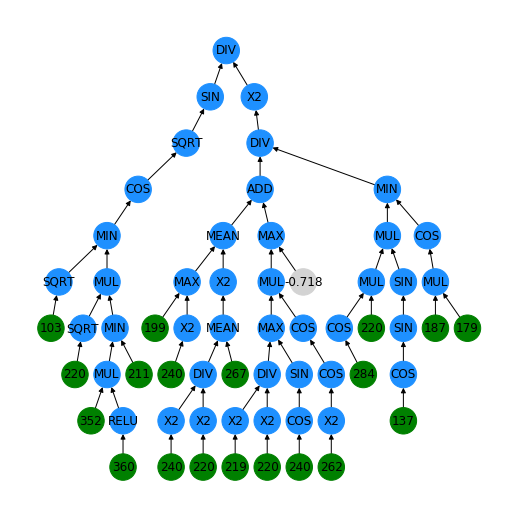

In [9]:
from GPUtils import get_graph
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


plt.figure(figsize=(7,7))
graph, labels, color_map = get_graph(gp_img_den.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)

Plot behavior of function approximation against groud truth:

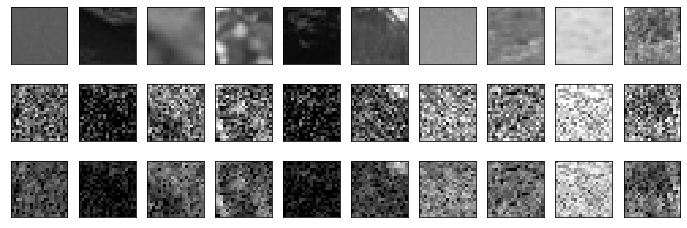

In [11]:
from matplotlib.colors import Normalize 

noise_mask = GP.predict(x_training[0:10])
reconstruction = x_training[0:10] - noise_mask

y_label = f['y_train']


norm = Normalize(vmin=0, vmax=1, clip=True)

n = 10  # how many digits we will display
plt.figure(figsize=(12, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(y_label[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_training[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.imshow(reconstruction[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

---

### Same example as above, but with _mezzanine_ functions enabled; higher performance, same amount of time

First we need to reshape the size of the minibatches, to account for the more (computational) costly mezzanine functions and perform the evolution in the same amount of time.

In [15]:
batchesX = x_train.reshape(60, 200, 21, 21)
batchesY = y_train.reshape(60, 200, 21, 21)

Next, we import the individual class to use, NonConvolutional _Mezzanine_ Filter, and declare both, the mezzanine functions to use, as well as the _trimmers_ that allow them to work (mezzanine function cannot work without _trimmers_).

In [16]:
from NonConvolutionalMezzanineFilter import *           # This is the GP individual we will use.

mezzanine = ['mMEAN', 'mSTD', 'mMAX', 'mMIN', 'mMED']
trimmers = ['TFull', 'TNorW', 'TNorE', 'TSouW', 'TSouE', 'TCenter3', 'TCenter5', 'TOuterR']
GeneticProgram.set_primitives(lowlevel=lowlevel, mezzanine=mezzanine, trimmers=trimmers)

#gp_individual_class = NonConvFilter            # Type of individual to evolve
ind_params = {'lateral_window_size':21, 'complexity':9, 'high_depth_allocation':.5} 

oper = [NonConvFilter.mutation,                 # Genetic operations to use.
        NonConvFilter.protected_crossover]      # notice how they are defined by the type of individual we will evolve

Initialize predictor as usual:

In [18]:
midGP = GeneticProgram(individual_class=NonConvFilter , 
                       ind_params=ind_params, 
                       operations=oper, 
                       operations_prob=oper_prob, 
                       operations_arity=oper_arity, 
                       pop_size=1000, 
                       epochs=1,
                       pop_dynamics="Steady_State", 
                       online=True, 
                       minimization=True,
                       n_jobs=4)

Trainig it / Evolve it

In [19]:
midGP.fit(batchesX, batchesY)

First evaluation time cost:  0:00:08.149535


100%|██████████| 60/60 [09:27<00:00,  9.45s/it, Training Fitness=0.00691]

Training fitness of best individual found:  0.006912361902234278


In [21]:
midGP.natural_score(x_test, y_test)

0.00811359

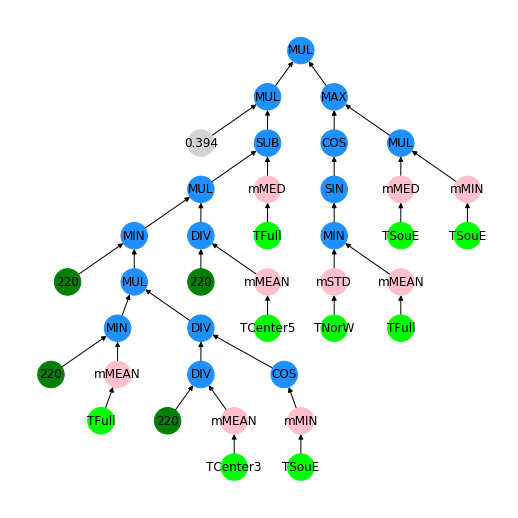

In [23]:
plt.figure(figsize=(7,7))
graph, labels, color_map = get_graph(midGP.model_.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)

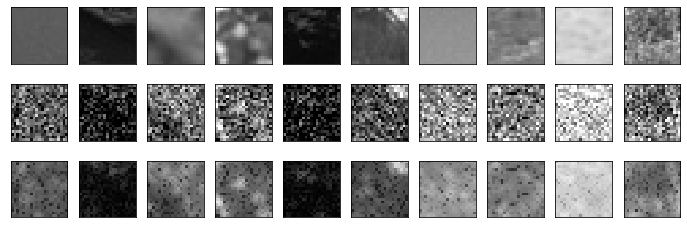

In [24]:
noise_mask = midGP.predict(x_training[0:10])
reconstruction = x_training[0:10] - noise_mask

y_label = f['y_train']


norm = Normalize(vmin=0, vmax=1, clip=True)

n = 10  # how many digits we will display
plt.figure(figsize=(12, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(y_label[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_training[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.imshow(reconstruction[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()